In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
from jupyterthemes import jtplot
jtplot.style('default')

In [2]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

<AxesSubplot:>

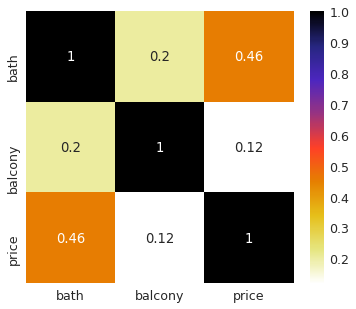

In [5]:
plt.figure(figsize=(6,5))
cor = df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)

balcony is least matter \
assuming some other parameters also matter least

In [6]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

since our datasize is large we can drop this Na values

In [8]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df3.shape

(13246, 5)

In [10]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

<ipython-input-11-d47496571a70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
df3.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [13]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
df3[-df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [16]:
def convert_sqft_to_num(x):
    t = x.split('-')
    if len(t) == 2:
        return (float(t[0]) + float(t[1]))/2
    try:
        return float(x)
    except:
        return None

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


In [18]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [19]:
df5['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [20]:
len(df5.location.unique())

1298

In [21]:
df5.location = df5.location.apply(lambda x: x.strip())

This removes the space from the from and the back, if there any

In [22]:
df5.location.describe()

count          13200
unique          1287
top       Whitefield
freq             533
Name: location, dtype: object

In [23]:
location_stats = df5['location'].value_counts(ascending = False)
location_stats

Whitefield            533
Sarjapur  Road        392
Electronic City       304
Kanakpura Road        264
Thanisandra           235
                     ... 
BEL Layout              1
elachenahalli           1
Maruthi Layout          1
1 Immadihalli           1
Prasanth Extension      1
Name: location, Length: 1287, dtype: int64

we can put the location which have less than 10 data points in other location

In [24]:
location_stats.values.sum()

13200

In [25]:
len(location_stats[location_stats > 10])

240

In [26]:
len(location_stats)

1287

In [27]:
len(location_stats[location_stats <= 10])

1047

In [28]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

Nagadevanahalli         10
Naganathapura           10
Sadashiva Nagar         10
Kalkere                 10
Nagappa Reddy Layout    10
                        ..
BEL Layout               1
elachenahalli            1
Maruthi Layout           1
1 Immadihalli            1
Prasanth Extension       1
Name: location, Length: 1047, dtype: int64

In [29]:
len(df5.location.unique())

1287

In [30]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 
                                                    else x)
len(df5.location.unique())

241

In [31]:
df5

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


Removing outlier\
this are data error or not data error but they represent the extrem error variation in our data sets\
they are valied but its best to remove them. they can create issues later on

In [32]:
df5[df5.total_sqft/df5.bhk < 300]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13277,other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,5 Bedroom,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


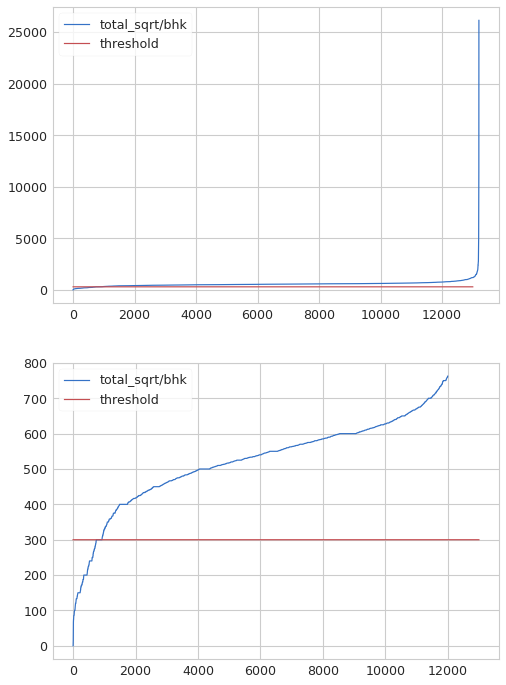

In [33]:
fig = plt.figure(figsize=(8, 12))
a = df5.total_sqft/df5.bhk
a = a.sort_values(ascending = True, ignore_index=True)
b = [300 for i in range(13000)]
plt.subplot(2, 1, 1)
plt.plot(a, label = 'total_sqrt/bhk')
plt.plot(range(13000), b, 'r', label = 'threshold')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(a[:12000], label = 'total_sqrt/bhk')
plt.plot(range(13000), b, 'r', label = 'threshold')
plt.legend()

In [34]:
df5.shape

(13200, 7)

In [35]:
df6 = df5[~(df5.total_sqft/df5.bhk < 300)]
df6.shape

(12456, 7)

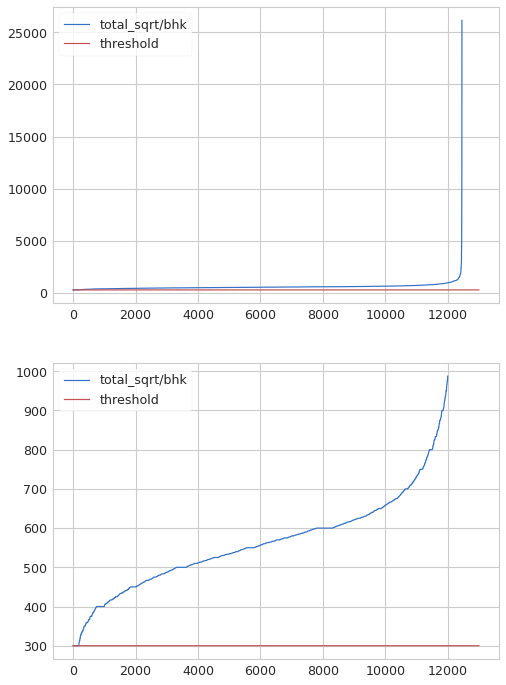

In [36]:
fig = plt.figure(figsize=(8, 12))
a = df6.total_sqft/df6.bhk
a = a.sort_values(ascending = True, ignore_index=True)
b = [300 for i in range(13000)]
plt.subplot(2, 1, 1)
plt.plot(a, label = 'total_sqrt/bhk')
plt.plot(range(13000), b, 'r', label = 'threshold')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(a[:12000], label = 'total_sqrt/bhk')
plt.plot(range(13000), b, 'r', label = 'threshold')
plt.legend()

In [37]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft < (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [38]:
df7 = remove_pps_outliers(df6)
df7

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.00,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.00,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.00,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.00,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.00,2,11983.805668
...,...,...,...,...,...,...,...
10237,other,2 BHK,1353.0,2.0,110.00,2,8130.081301
10238,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
10239,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
10240,other,2 BHK,1075.0,2.0,48.00,2,4465.116279


what is in a location price of 1 bhk > price of 2 bhk. apply for other too\
outlier


In [39]:
df7.bhk.describe()

count    10242.000000
mean         2.572642
std          0.897242
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: bhk, dtype: float64

In [40]:
len(df7[df7.bhk > 4])

221

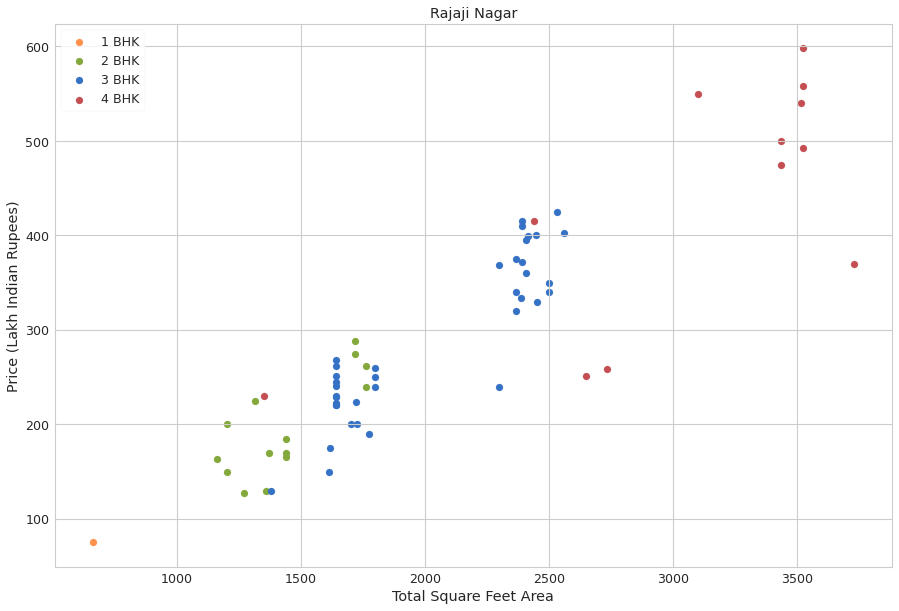

In [41]:
def plot_scatter_chart(df, location):
    c = ['y', 'g', 'b', 'r']
    for i in range(1,5):
        b = 'bhk'+str(i)
        b = df[(df.location==location) & (df.bhk==i)]
        matplotlib.rcParams['figure.figsize'] = (15,10)
        plt.scatter(b.total_sqft, b.price, color=c[i-1], label=str(i)+' BHK', s=50)
        plt.xlabel("Total Square Feet Area")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(location)
        plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

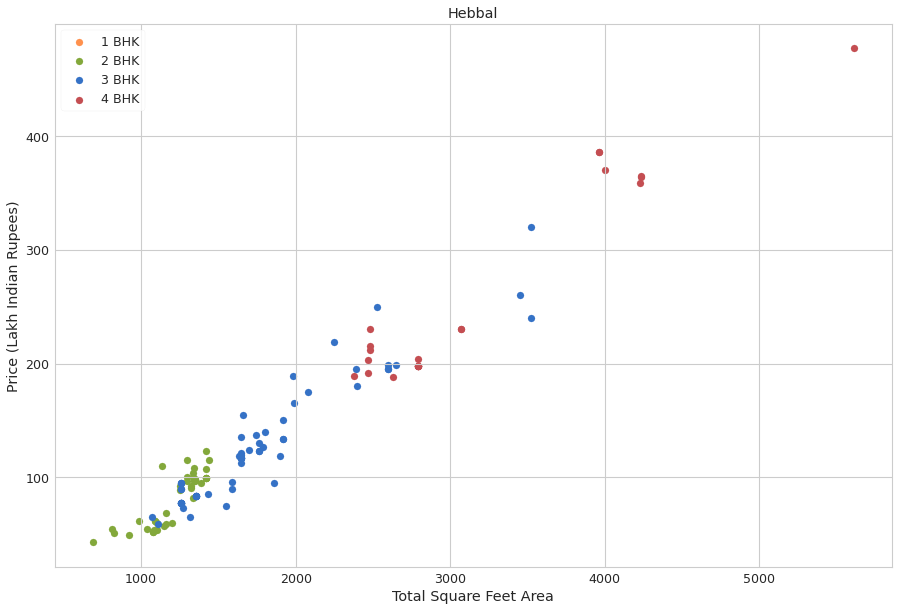

In [42]:
plot_scatter_chart(df7,"Hebbal")

In [43]:
def remove_bhk_outlier(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                                'mean': np.mean(bhk_df.price_per_sqft),
                                'std': np.std(bhk_df.price_per_sqft),
                                'count': bhk_df.shape[0]
            }
        keys = list(bhk_stats.keys())
        a = 0
        for bhk, bhk_df in location_df.groupby('bhk'):
            for i in keys[a-1:a]:
                stats = bhk_stats.get(i)
                if stats and stats['count'] > 5:
                    exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)                            
            a += 1
    return df.drop(exclude_indices, axis = 'index')
        
# remove_bhk_outlier(df7)
df8 = remove_bhk_outlier(df7)
df8.shape

(7308, 7)

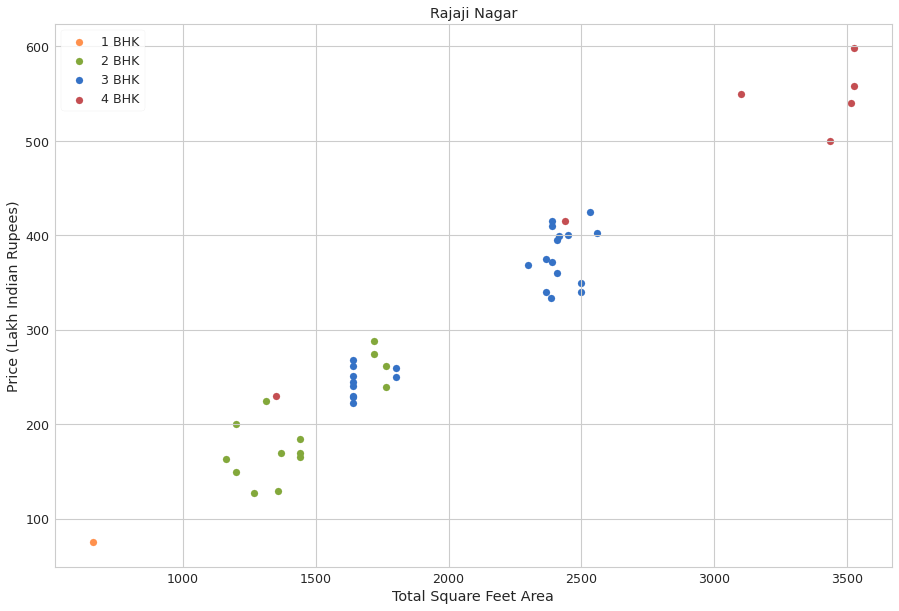

In [44]:
plot_scatter_chart(df8,"Rajaji Nagar")

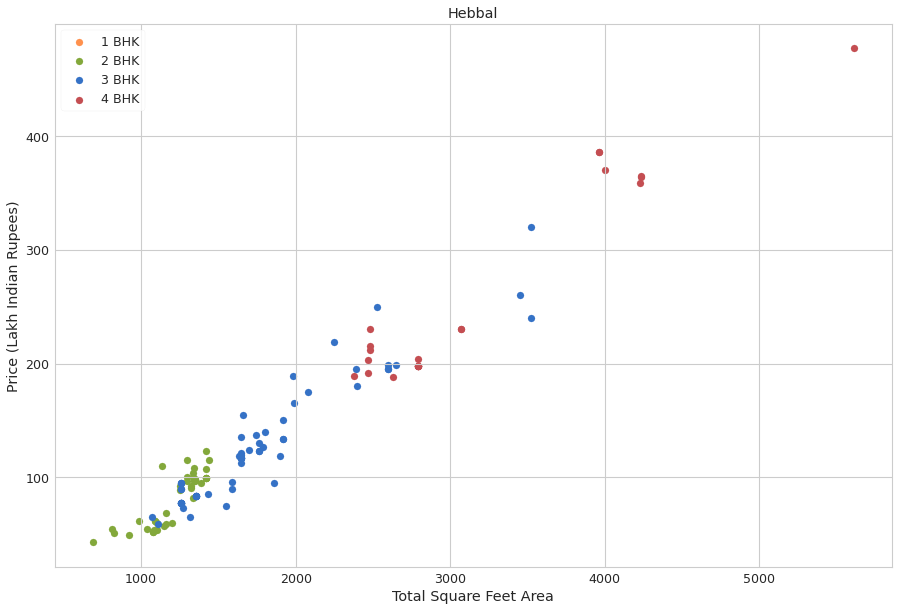

In [45]:
plot_scatter_chart(df7,"Hebbal")

Text(0, 0.5, 'Count')

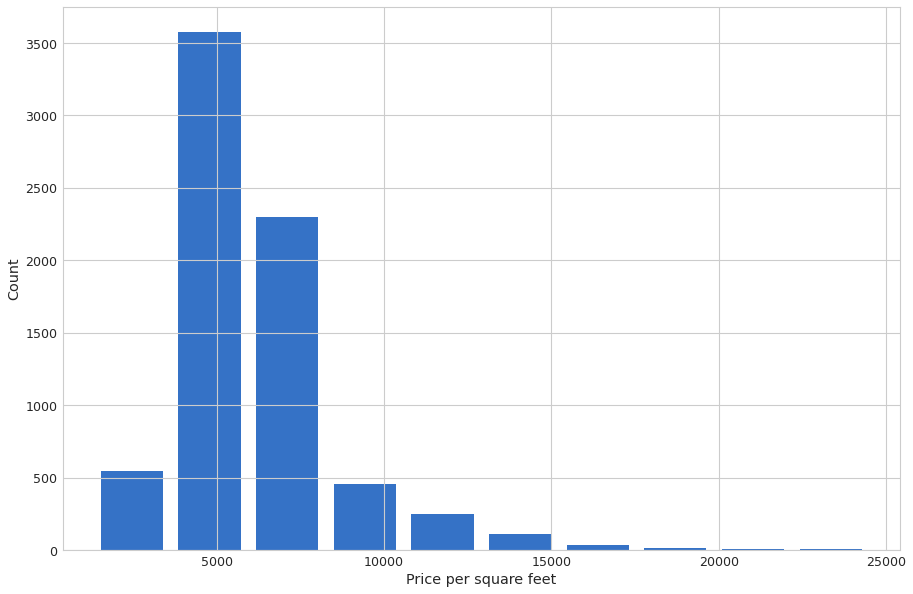

In [46]:
plt.hist(df8.price_per_sqft, rwidth = 0.8)
plt.xlabel('Price per square feet')
plt.ylabel('Count')

exploring bath feature

In [47]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [48]:
df8[df8.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

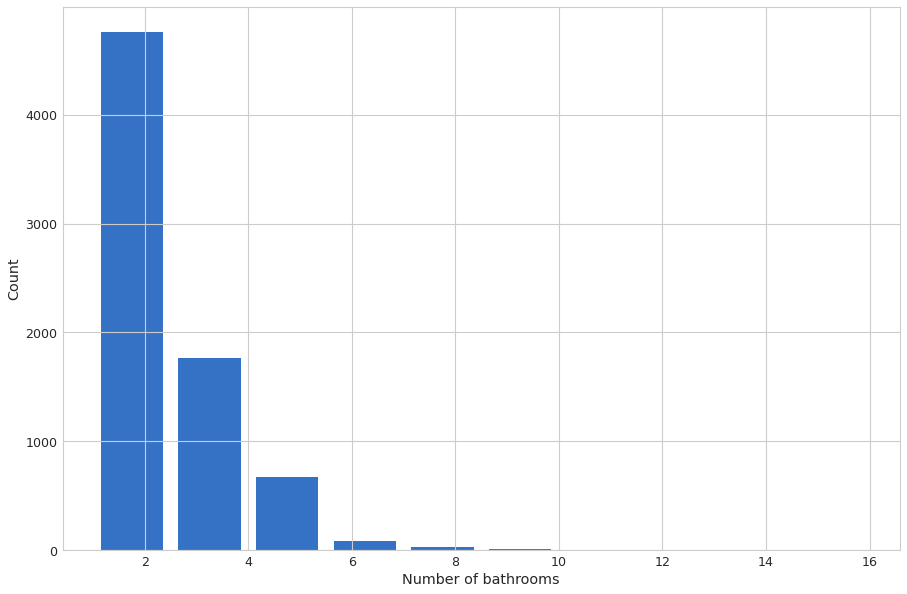

In [49]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

No. of bathrooms !> No. of rooms + 2

In [50]:
df8[df8.bath >= df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
36,2nd Stage Nagarbhavi,6 Bedroom,3000.0,8.0,451.0,6,15033.333333
37,2nd Stage Nagarbhavi,6 Bedroom,2400.0,8.0,450.0,6,18750.000000
530,Arekere,4 BHK,2710.0,6.0,142.0,4,5239.852399
580,BTM 2nd Stage,3 Bedroom,1260.0,5.0,185.0,3,14682.539683
813,Bannerghatta,4 BHK,3012.0,6.0,250.0,4,8300.132802
...,...,...,...,...,...,...,...
9914,other,4 BHK,6652.0,6.0,510.0,4,7666.867108
10035,other,2 BHK,600.0,4.0,70.0,2,11666.666667
10090,other,3 Bedroom,5656.0,5.0,499.0,3,8822.489392
10203,other,4 BHK,6652.0,6.0,660.0,4,9921.828022


In [51]:
df9 = df8[df8.bath < df8.bhk+2]
df9

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10233,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10234,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10237,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10238,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [52]:
df10 = df9.drop(['size', 'price_per_sqft'], axis = 'columns')
df10

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10233,other,1200.0,2.0,70.0,2
10234,other,1800.0,1.0,200.0,1
10237,other,1353.0,2.0,110.0,2
10238,other,812.0,1.0,26.0,1


In [53]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df11 = pd.concat([df10, dummies.drop('other', axis = 'columns')], axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df12 = df11.drop('location', axis='columns')
df12.head(3)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df12.shape

(7231, 244)

In [57]:
x = df12.drop('price', axis='columns')
x.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
y = df12.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [60]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg.score(x_test, y_test)

0.8595869358255852

In [61]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0,)
cross_val_score(LinearRegression(), x, y, cv = cv)

array([0.74724022, 0.86518325, 0.87183055, 0.85560587, 0.86364915])

In [62]:
def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params' : {
                'normalize' : [True, False]
            }
        },
        'lasso' : {
            'model' : Lasso(),
            'params' : {
                'alpha' : [1, 2],
                'selection' : ['random', 'cyclic']
            }
        },
        'decision_tree' : {
            'model' : DecisionTreeRegressor(),
            'params' : {
                'criterion' : ['mse', 'friedman_mse'],
                'splitter' : ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score=False)                 
        gs.fit(x,y)
        scores.append({
            'model' : algo_name,
            'best_score' : gs.best_score_,
            'best_params' : gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [63]:
find_best_model_using_gridsearchcv(x, y)

,model,best_score,best_params
0,linear_regression,0.840702,{'normalize': True}
1,lasso,0.710926,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.698207,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


LinearRegression gives the max score\
Thus, we will be using LinearRegression for predicting the model

In [64]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [65]:
np.where(x.columns == '5th Block Hbr Layout')[0][0]

7

In [66]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(x.columns == location)[0][0]
    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if loc_index >= 0:
        X[loc_index] = 1
    return lin_reg.predict([X])[0]

In [67]:
predict_price("1st Phase JP Nagar", 1000, 2, 2)

95.70229772106151

In [68]:
predict_price("1st Phase JP Nagar", 1000, 2, 3)

96.42682350837791

In [69]:
predict_price("Indira Nagar", 1000, 3, 3)

204.6935949746628

done with model building process\
now, we have to save this to over picker file

In [70]:
import pickle
with open('banglore_home_price_model.pickle', 'wb') as f:
    pickle.dump(lin_reg, f)

In [71]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))